# **Chemical Bonding Simulation**

In [1]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import RandomState

In [2]:
a = 1,2
b= 9,15
list(np.array(a)-np.array(b)) 

[-8, -13]

## Functions

In [3]:
def calculate_action_probability(state):
  exponentiated_potential = np.exp(-theta[state[0]][state[1]])
  action_probability = 1/(exponentiated_potential+1)
  return action_probability

In [4]:
def transition(state, action_probability):
  rand = np.random.random()
  
  if state[0] > 19:
    action = 0
    action_probability = 1
  elif state[0] < 1:
    action = 1
    action_probability = 1
  else:
    if rand < action_probability:
      action = 1
      action_probability = action_probability
    else:
      action = 0
      action_probability = 1-action_probability
  return action, action_probability

In [5]:
def untrained_transition(state, action_probability):
  rand = np.random.random()
  z, pplus, pminus = dynamics(0.5, 5, 1)
  
  if state[0] > 19:
    action = 0
    action_probability = 1
  elif state[0] < 1:
    action = 1
    action_probability = 1
  else:
    if rand < pplus[state[0]]:
      action = 1
      action_probability = pplus[state[0]]
    else:
      action = 0
      action_probability = 1-pplus[state[0]]
  return action, action_probability

In [6]:
def update_state(state, action):
  state[0] += 2*action - 1
  state[1] += 1
  return state

In [7]:
def generate_reward(state):

   if state[1] == T:
     reward = -1*abs(state[0]-16)
   else:
     reward = 0

   return reward

In [8]:
def calculate_eligibility(state, action, action_probability):
  if action == 1:
    eligibility = 1 - action_probability
  else:
    eligibility = -action_probability
  return eligibility

In [9]:
def find_value(state):
  return value_table[state[0]][state[1]]

In [10]:
def update_value(state, next_state, reward, learning_rate_beta):
  past_value = find_value(state)
  current_value = find_value(next_state)
  td_error = current_value + reward - past_value
  value_table[state[0]][state[1]] += learning_rate_beta * td_error
  return value_table

In [11]:
def update_theta(state, next_state, reward, learning_rate, eligibility):
  past_value = find_value(state)
  current_value = find_value(next_state)
  td_error = current_value + reward - past_value
  theta[state[0]][state[1]] += learning_rate * td_error * eligibility
  return theta

In [12]:
def gaussian_derivative(x,sigma):
  Gaussian = -np.exp(-x**2/sigma**2)*x/(2*sigma**2)
  return Gaussian

In [13]:
def dynamics(a,zlim,sigma):
  N = 2*a
  z = np.arange(-zlim,zlim,(2*zlim)/21)
  f = gaussian_derivative(z,sigma)

  pminus = (-f+a)/N
  pplus = (f+a)/N

  pminus[0] = 0.0001
  pplus[0] = 1

  pminus[-1] = 1
  pplus[-1] = 0.0001

  return z, pminus, pplus

In [14]:
def kl_regularisation(state, action, action_probability):

  z, pminus, pplus = dynamics(0.5, 5, 0.75)
  
  if action == 1:
    prob = pplus[state[0]]
  else:
    prob = pminus[state[0]]
  #print(prob)

  return -math.log(action_probability/prob)

Plot Gaussian

Text(0, 0.5, 'P')

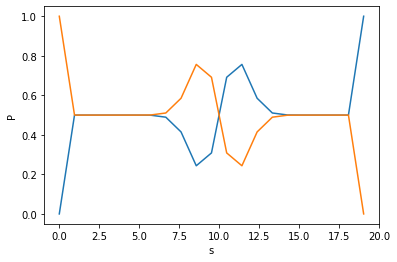

In [15]:
z, p1, p2 = dynamics(0.5, 5, 0.75)

x = 2*(5+z)
plt.plot(x,p1)
plt.plot(x,p2)

plt.xlabel('s')
plt.ylabel('P')

# Untrained evaluation

Plot 30 trajectories with untrained policy

In [16]:
T = 30
dimensions = (2*T+1,T+1)
theta = np.zeros(dimensions)
state = [0,0]

In [17]:
def generate_samples_untrained(N):
  trajectories = []
  average_return = 0
  for i in range(0, N):
    state = [0,0]
    trajectory = [state.copy()]
    trajectory_reward = 0
    for i in range (0,T):
      action_probability = calculate_action_probability(state.copy())
      action, action_probability = untrained_transition(state.copy(), action_probability)
      next_state = update_state(state.copy(), action)
      reward = generate_reward(next_state.copy())
      trajectory_reward += reward
      state = next_state
      trajectory.append(state.copy())
    trajectories.append(trajectory.copy())
    average_return += (trajectory_reward - average_return)/(i+1)
  return trajectories, average_return

In [18]:
untrained, avg = generate_samples_untrained(30)

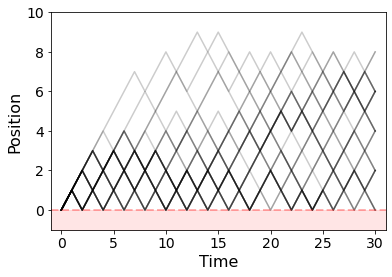

-7.8183809804677455


In [19]:
min_y = np.min(np.array(untrained)[:,:,0]) - 1
max_y = np.max(np.array(untrained)[:,:,0]) + 1

plt.plot(np.array(untrained)[:,:,0].T, c = 'k', alpha = 0.2)
plt.scatter([T], [150], c = 'k', marker = 'o', s = 100)
plt.plot([-1, T+1], [0, 0], lw = 2, c = 'r', ls = '--', alpha = 0.3)
plt.fill_between([-1, T+1], [0, 0], [min_y, min_y], color = 'r', alpha = 0.1)
plt.xlim(-1, T+1)
plt.ylim(min_y, max_y)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Time", fontsize=16)
plt.ylabel("Position", fontsize=16)
plt.show()
print(avg)

# Training with actor critic

Set variables

In [20]:
T = 30
N = 10000
dimensions = (2*T+1,T+1)
theta = np.zeros(dimensions)
value_table = np.zeros(dimensions)
learning_rate = 0.01
learning_rate_beta = 0.6
return_learning_rate = 0.1

In [21]:
def actor_critic(N, avg):
  trajectories = []
  trajectory_rewards = [] #stores trajectory rewards
  running_average_return = [] #store running average return
  for i in range(0, N):
    state = [0,0]
    trajectory = [state.copy()]
    actions = []
    rewards = []
    eligibilities = []
    action_probabilities = []
    trajectory_reward = 0
    for i in range (0,T):
      action_probability = calculate_action_probability(state.copy())

      action, action_probability = transition(state.copy(), action_probability)
      actions.append(action) #store actions
      action_probabilities.append(action_probability) #store action probabilities

      eligibility = calculate_eligibility(state.copy(), action, action_probability)
      eligibilities.append(eligibility) #store eligibilities
      
      next_state = update_state(state.copy(), action)
  
      reward = generate_reward(next_state.copy())+ kl_regularisation(state, action, action_probability)
      rewards.append(reward) #store rewards

      trajectory_reward += reward 

      #update the value for past state
      update_value(state, next_state, reward, learning_rate_beta)

      #update theta
      update_theta(state, next_state, reward, learning_rate, eligibility)

      state = next_state #set next state as state
      trajectory.append(state.copy()) #add next state to trajectory

    trajectories.append(trajectory.copy()) #append trajectory to global list
    trajectory_rewards.append(trajectory_reward) # append reward for trajectory

    #average_return
    avg += return_learning_rate * (trajectory_reward - avg)
    running_average_return.append(avg)

  return trajectory_rewards, running_average_return

In [22]:
ac_rewards, ac_running_return = actor_critic(N, avg)

Plot episodic returns

Text(0, 0.5, 'Episodic returns')

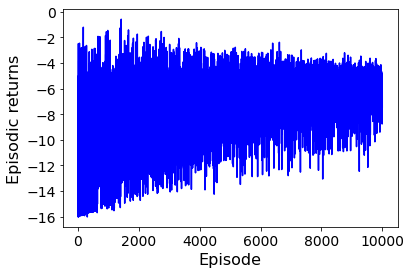

In [23]:
plt.plot(ac_rewards, c = 'b')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Episode", fontsize=16)
plt.ylabel("Episodic returns", fontsize=16)

Plot running returns

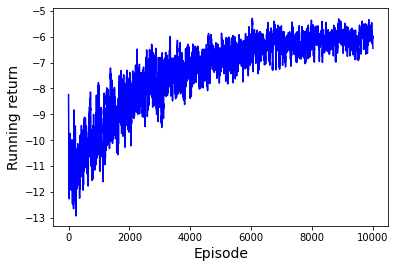

In [24]:
plt.plot(ac_running_return, c = 'b')
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Running return", fontsize=14)
plt.show()
#print(ac_running_return)

#Trained policy evaluation

With updated theta, plot 30 trajectories and compare to untrained policy

In [25]:
def generate_samples_trained(N):
  trajectories = []
  trajectory_rewards = []
  average_return = 0
  for i in range(0, N):
    state = [0,0,0]
    trajectory = [state.copy()]
    trajectory_reward = 0
    for i in range (0,T):
      action_probability = calculate_action_probability(state.copy())
      action, action_probability = transition(state.copy(), action_probability)
      next_state = update_state(state.copy(), action)
      reward = generate_reward(next_state.copy())
      trajectory_reward += reward
      state = next_state
      trajectory.append(state.copy())
    trajectories.append(trajectory.copy())
    trajectory_rewards.append(trajectory_reward)
    #average_return += (trajectory_reward - average_return)/(i+1)
    
  return trajectories, trajectory_rewards

In [26]:
sample, traj_rewards = generate_samples_trained(30)

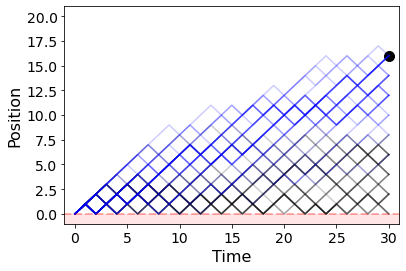

In [27]:
min_y = - 1
max_y = 21

plt.plot(np.array(untrained)[:,:,0].T, c = 'k', alpha = 0.2)
plt.plot(np.array(sample)[:,:,0].T, c = 'b', alpha = 0.2)
plt.scatter([T], [16], c = 'k', marker = 'o', s = 100)
plt.plot([-1, T+1], [0, 0], lw = 2, c = 'r', ls = '--', alpha = 0.3)
plt.fill_between([-1, T+1], [0, 0], [min_y, min_y], color = 'r', alpha = 0.1)
plt.xlim(-1, T+1)
plt.ylim(min_y, max_y)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Time", fontsize=16)
plt.ylabel("Position", fontsize=16)
plt.show()
#print(avg_return)

In [28]:
from statistics import mean
mean(traj_rewards)

-3

# Data and graphs

## Histogram

### Untrained

In [29]:
# intializing the arr
arr = np.matrix.flatten(np.array(untrained)[:,:,0].T)

Text(0, 0.5, 'Frequency')

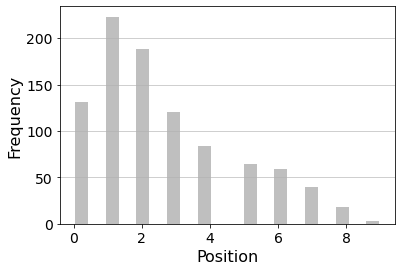

In [30]:
# An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist(x=arr, bins=20, color='grey', alpha=0.5, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Position', fontsize=16)
plt.ylabel('Frequency', fontsize=16)

### Trained

In [31]:
# intializing the arr
arr2 = np.matrix.flatten(np.array(sample)[:,:,0].T)

Text(0, 0.5, 'Frequency')

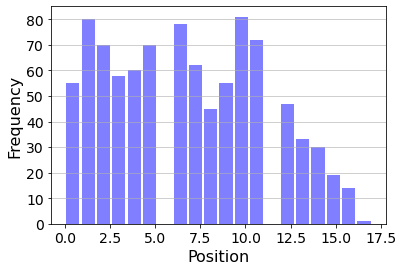

In [32]:
# An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist(x=arr2, bins=20, color='blue', alpha=0.5, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Position', fontsize=16)
plt.ylabel('Frequency', fontsize=16)